In [94]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [95]:
with open("names.txt", 'r') as file:
    words = file.read().splitlines()
    
chars = sorted(list(set(''.join(words))))
stoi = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [96]:
import random
random.seed(42)
random.shuffle(words)

In [97]:
vocab_size = len(itos)
block_size = 8
def build_dataset(words):
    X, Y  = [], []
    for w in words:
        context = [0] * block_size
        for char in w + ".":
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:]) 


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [98]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, X):
        self.out = X @ self.W
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.W] if self.bias is None else [self.W, self.bias]
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, monumentum=0.1):
        self.eps = eps
        self.monumentum = monumentum
        self.training=True
        #params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, X):
        if self.training:
            dim = tuple(range(X.ndim - 1))
            xmean = X.mean(dim, keepdim=True)
            xvar = X.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = self.gamma * (X - xmean) / torch.sqrt(xvar + self.eps) + self.beta
        with torch.no_grad():
            self.running_mean = (1-self.monumentum)*self.running_mean + self.monumentum * xmean
            self.running_var = (1-self.monumentum)*self.running_var + self.monumentum * xvar
            
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, n_embeddings, dim_embeddings):
        self.W = torch.randn((n_embeddings, dim_embeddings))
    
    def __call__(self, x):
        self.out = self.W[x]
        return self.out
    
    def parameters(self):
        return [self.W]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n) #[32, 8, 10] -> [32, 4, 20]
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, *args):
        self.layers = list(args)
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [99]:
torch.manual_seed(42)

In [100]:
Xtr.ndim

2

In [ ]:
n_embd = 10
n_hidden = 68
model = Sequential(
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
)

with torch.no_grad():
    model.layers[-1].W *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [102]:
max_steps = 200_000
batch_size = 32

lossi = []
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    x = Xb
    logits = model(x)
    loss = F.cross_entropy(logits, Yb)
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 1000_000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad      
    
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): 4f}')    
    lossi.append(loss.log10().item())

      0/ 200000:  3.314219
  10000/ 200000:  2.209562
  20000/ 200000:  2.149511
  30000/ 200000:  2.123186
  40000/ 200000:  1.962860
  50000/ 200000:  2.418318
  60000/ 200000:  1.963307
  70000/ 200000:  1.895956
  80000/ 200000:  2.188387
  90000/ 200000:  1.816131
 100000/ 200000:  1.593117
 110000/ 200000:  2.360672
 120000/ 200000:  2.366994
 130000/ 200000:  1.909774
 140000/ 200000:  2.228450
 150000/ 200000:  1.711811
 160000/ 200000:  1.940310
 170000/ 200000:  2.262171
 180000/ 200000:  2.068669
 190000/ 200000:  1.776261


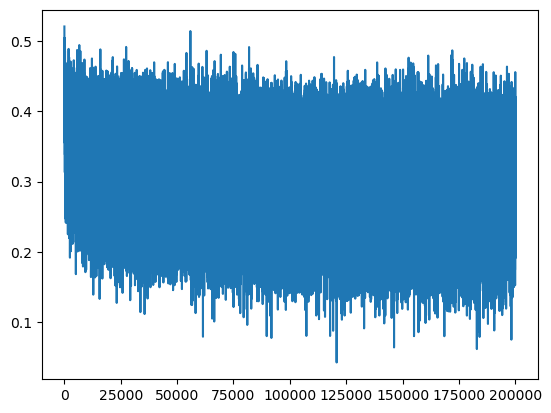

In [103]:
plt.plot(lossi)
plt.show()

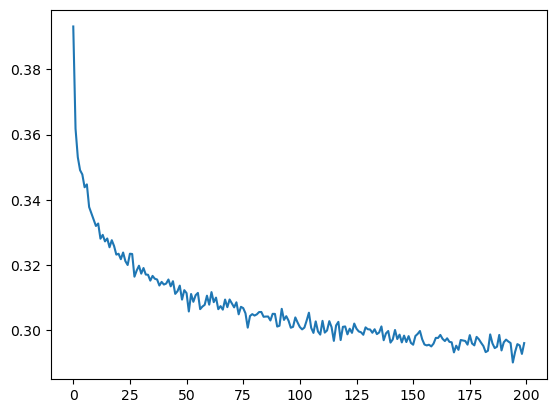

In [104]:
plt.plot(
    torch.tensor(lossi).view(-1, 1000).mean(1)
)

In [105]:
for layer in model.layers:
    layer.training = False

In [106]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': {Xtr, Ytr},
        'valid': {Xdev, Ydev},
        'test': {Xte, Yte}
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('valid')

train 1.949150800704956
valid 2.052490472793579


In [110]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])